<a href="https://colab.research.google.com/github/HarshiniBhat/Model-Building/blob/main/N5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Target:
To increase the efficiency of the model by adding  rotation transformation and LR Scheduler. 

## Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt # for visualisation
from tqdm import tqdm

## Data Transformations

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                     
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                     
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


## Creating Train/Test

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Dataloader Arguments and loading the data

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Visualising Images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


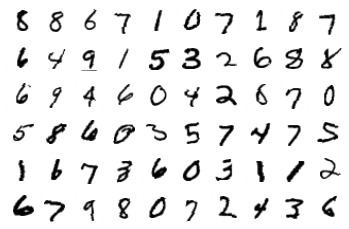

In [6]:
dataset = iter(train_loader)
images, labels = dataset.next()

print(images.shape)
print(labels.shape)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Defining the model

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    drop = 0.025
    self.convblock1 = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=3, padding=0, bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(drop),
    )

    self.convblock2 = nn.Sequential(
        nn.Conv2d(8, 16, kernel_size=3, padding=0, bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(drop),
    )
    
    self.pool1 = nn.MaxPool2d(2,2)
    self.transition = nn.Sequential(
        nn.Conv2d(16, 8, kernel_size=1, bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(drop),
    )

    self.convblock3 = nn.Sequential(
        nn.Conv2d(8, 12, kernel_size=3, padding=0, bias=False),
        nn.BatchNorm2d(12),
        nn.ReLU(),
        nn.Dropout(drop),
        nn.Conv2d(12, 16, kernel_size=3, padding=0, bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(drop),
        nn.Conv2d(16, 20, kernel_size=3, padding=0, bias=False),
        nn.BatchNorm2d(20),
        nn.ReLU(),
        nn.Dropout(drop),
    )

    self.gap = nn.AvgPool2d(6)

    self.convblock4 = nn.Sequential(
        nn.Conv2d(20, 24, kernel_size=1, bias=False),
        nn.BatchNorm2d(24),
        nn.ReLU(),
        nn.Dropout(drop),
        nn.Conv2d(24, 10, kernel_size=1, bias=False),
        nn.ReLU(),
    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.pool1(x)
    x = self.transition(x)

    x = self.convblock3(x)
    x = self.gap(x)
    x = self.convblock4(x)

    x = x.view(-1,10)
    return F.log_softmax(x, dim=-1)


## Model Summary

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Training and Testing

In [9]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    # Update LR
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
NUM_EPOCHS = 15
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.017, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))


for epoch in range(1,NUM_EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.38077983260154724 Batch_id=468 Accuracy=62.51: 100%|██████████| 469/469 [00:22<00:00, 21.29it/s]



Test set: Average loss: 0.4338, Accuracy: 8696/10000 (86.96%)

EPOCH: 2


Loss=0.18096864223480225 Batch_id=468 Accuracy=90.63: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]



Test set: Average loss: 0.0811, Accuracy: 9795/10000 (97.95%)

EPOCH: 3


Loss=0.09088011831045151 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:22<00:00, 21.24it/s]



Test set: Average loss: 0.0694, Accuracy: 9802/10000 (98.02%)

EPOCH: 4


Loss=0.0809013620018959 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:21<00:00, 21.98it/s]



Test set: Average loss: 0.0452, Accuracy: 9860/10000 (98.60%)

EPOCH: 5


Loss=0.03515147417783737 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]



Test set: Average loss: 0.0320, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.01072074007242918 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]



Test set: Average loss: 0.0261, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.01881556585431099 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]



Test set: Average loss: 0.0318, Accuracy: 9904/10000 (99.04%)

EPOCH: 8


Loss=0.017045551910996437 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]



Test set: Average loss: 0.0291, Accuracy: 9906/10000 (99.06%)

EPOCH: 9


Loss=0.17183703184127808 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:21<00:00, 21.88it/s]



Test set: Average loss: 0.0242, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.014050036668777466 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]



Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.007068320643156767 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]



Test set: Average loss: 0.0193, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


Loss=0.009403491392731667 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:22<00:00, 21.31it/s]



Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.04482561722397804 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:21<00:00, 21.55it/s]



Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.019093163311481476 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:22<00:00, 21.26it/s]



Test set: Average loss: 0.0169, Accuracy: 9951/10000 (99.51%)

EPOCH: 15


Loss=0.043417736887931824 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]



Test set: Average loss: 0.0165, Accuracy: 9955/10000 (99.55%)



## Plotting the loss and accuracy curve

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

RESULT: 
- Parameters : 7752
- Best Training Accuracy: 99.18%
- Best Test Accuracy: 99.55%

This model is a good model as we have reached an accuracy of 99.55% with less than 10K parameters. 
